In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans #for kmeans algorithm

#For dimensionality reduction.
from sklearn.decomposition import PCA #pca from decomposition module.
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition #decomposition module
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.backends.backend_tkagg
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sn
#from wordcloud import WordCloud,ImageColorGenerator

In [ ]:
# Loading the data 

# Loading Aisles data into Aisles
aisles = pd.read_csv('aisles.csv')

# Loading Departments data into Departments
departments = pd.read_csv('departments.csv')

# Loading Training order data into orderProductsTrain
orderProductsTrain = pd.read_csv('order_products__train.csv')

# Loading the Orders into Orders
orders = pd.read_csv('orders.csv')

# Loading Products data into Products
products = pd.read_csv('products.csv')

# Loading Prior order data into orderProductsPrior
orderProductsPrior = pd.read_csv('order_products__prior.csv')

In [3]:
#checking if dfs have nulls one by one
aisles.isnull().sum()
departments.isnull().sum()
products.isnull().sum()
orderProductsPrior.isnull().sum()
orderProductsTrain
orders.isnull().sum() # orders dataset has some nulls. We will drop them.

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [4]:
orders.dropna(inplace=True)

In [5]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0


In [6]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
orderProductsTrain.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
orderProductsPrior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


# Models

**1. Create Product predictor variables**

In [11]:
# 1) Total number of orders per product (prod_orders)
# 2) Total number of reorders per product (prod_reorder)
# 3) Probability a product is reordered after the first order (reorder_prob= prod_2nd_orders/prod_1st_orders)
# 4) Reorders per total number of orders of the product (prod_reorder_ratio)
# 5) In average how many times a product has been purchased by the users who purchased it at least once?
#(reorder_times=prod_reorder/prod_1st_orders +1)
# 6) The average order in which the product is put to cart (position_in_cart)

In [12]:
# merge order_prior, products, aisels, department
prior_df = pd.merge(orderProductsPrior, products, on='product_id', how='left')
prior_df=pd.merge(prior_df, aisles, on='aisle_id', how='left')
prior_df = pd.merge(prior_df, departments, on='department_id', how='left')

# merge orders, order_prior
prior_df = pd.merge(orders, prior_df, on='order_id', how='inner')
prior_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages
1,2398795,1,prior,2,3,7,15.0,10258,2,0,Pistachios,117,19,nuts seeds dried fruit,snacks
2,2398795,1,prior,2,3,7,15.0,12427,3,1,Original Beef Jerky,23,19,popcorn jerky,snacks
3,2398795,1,prior,2,3,7,15.0,13176,4,0,Bag of Organic Bananas,24,4,fresh fruits,produce
4,2398795,1,prior,2,3,7,15.0,26088,5,1,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks


In [13]:
# create product df (prd)
gp = prior_df.groupby('product_id')
prd = pd.DataFrame(gp.size(), columns=['prod_orders'])
prd['prod_reorder'] = gp['reordered'].agg('sum')
prd.reset_index()

tmp = prior_df.copy()
gp = prior_df.groupby(['user_id', 'product_id'])
tmp['prod_order'] = gp.cumcount()
prd['prod_1st_orders'] = tmp[tmp['prod_order']==0].groupby('product_id')['prod_order'].count()
prd['prod_2nd_orders'] = tmp[tmp['prod_order']==1].groupby('product_id')['prod_order'].count()
#del tmp

prd['reorder_prob'] = prd.prod_2nd_orders/prd.prod_1st_orders
prd['reorder_times'] = [i+1 for i in prd.prod_reorder/prd.prod_1st_orders]
prd['prod_reorder_ratio'] = prd.prod_reorder/prd.prod_orders
prd = prd.drop(['prod_1st_orders', 'prod_2nd_orders'], axis=1)
#del products
print('Done')
print()

Done



In [14]:
prd.head()

,prod_orders,prod_reorder,reorder_prob,reorder_times,prod_reorder_ratio
product_id,,,,,
1,1754,1136,0.399096,2.710843,0.647662
2,87,12,0.106667,1.160000,0.137931
3,260,203,0.457143,3.900000,0.780769
4,290,147,0.331325,1.885542,0.506897
5,14,9,0.500000,2.500000,0.642857


In [15]:
add_to_cart=prior_df.groupby('product_id')['add_to_cart_order'].mean().to_frame('position_to_cart')
add_to_cart = add_to_cart.reset_index()
add_to_cart.head()

,product_id,position_to_cart
0,1,5.785063
1,2,9.241379
2,3,6.284615
3,4,9.337931
4,5,6.714286


In [16]:
#Merge the prd DataFrame with Addtocart
prd=prd.merge(add_to_cart, on='product_id',how='left')
prd.head()

,product_id,prod_orders,prod_reorder,reorder_prob,reorder_times,prod_reorder_ratio,position_to_cart
0,1,1754,1136,0.399096,2.710843,0.647662,5.785063
1,2,87,12,0.106667,1.160000,0.137931,9.241379
2,3,260,203,0.457143,3.900000,0.780769,6.284615
3,4,290,147,0.331325,1.885542,0.506897,9.337931
4,5,14,9,0.500000,2.500000,0.642857,6.714286


In [17]:
prd.isnull().sum()

product_id               0
prod_orders              0
prod_reorder             0
reorder_prob          4766
reorder_times            0
prod_reorder_ratio       0
position_to_cart         0
dtype: int64

In [18]:
#reorder_prob has 4766 rows with NaN values, 
#this happens as there might be products that the customer did not buy on its after first order. 
#For these cases, we turn NaN values into zero (0) with .fillna(0) method.

In [19]:
prd = prd.fillna(0)
prd.head()

,product_id,prod_orders,prod_reorder,reorder_prob,reorder_times,prod_reorder_ratio,position_to_cart
0,1,1754,1136,0.399096,2.710843,0.647662,5.785063
1,2,87,12,0.106667,1.160000,0.137931,9.241379
2,3,260,203,0.457143,3.900000,0.780769,6.284615
3,4,290,147,0.331325,1.885542,0.506897,9.337931
4,5,14,9,0.500000,2.500000,0.642857,6.714286


**2. Create User Predictor Variables**

In [20]:
# 1) Total number of orders per user (user_total_orders)
# 2) How frequent a customer has reordered products? (user_reordered_ratio)
# 3) Average day of the week the user makes a purchase? (user_ave_dow)

In [21]:
user_orders = prior_df.groupby('user_id')['order_number'].max().to_frame('user_total_orders')
user_orders = user_orders.reset_index()
user_orders.head()

,user_id,user_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [22]:
user_reorder = prior_df.groupby('user_id')['reordered'].mean().to_frame('user_reordered_ratio')
user_reorder = user_reorder.reset_index()
user_reorder.head()

,user_id,user_reordered_ratio
0,1,0.759259
1,2,0.510989
2,3,0.705128
3,4,0.071429
4,5,0.538462


In [23]:
user_ave_dow=prior_df.groupby('user_id')['order_dow'].mean().to_frame('user_ave_dow')
user_ave_dow=user_ave_dow.reset_index()
user_ave_dow.head()

,user_id,user_ave_dow
0,1,2.703704
1,2,2.005495
2,3,1.012821
3,4,4.357143
4,5,1.038462


In [24]:
#merge user_orders, user_reorder and user_ave_dow
user_df = user_orders.merge(user_reorder, on='user_id', how='left')
user_df=user_df.merge(user_ave_dow,on='user_id', how='left')
user_df.head()

,user_id,user_total_orders,user_reordered_ratio,user_ave_dow
0,1,10,0.759259,2.703704
1,2,14,0.510989,2.005495
2,3,12,0.705128,1.012821
3,4,5,0.071429,4.357143
4,5,4,0.538462,1.038462


**3. Create User-Product Predictor Variables**

In [25]:
# 1) The total times a user ordered the same product (up_times_orders)
# 2) Reorder ratio of the user for each product (up_reorder_ratio)

In [26]:
#The total times a user ordered the same product
up = prior_df.groupby(by=['user_id', 'product_id'])['order_id'].agg('count').to_frame('up_times_order')
up=up.reset_index()
up.head()

,user_id,product_id,up_times_order
0,1,196,9
1,1,10258,9
2,1,10326,1
3,1,12427,9
4,1,13032,3


In [27]:
#reorder ratio of the user for each product.
up_reorder = prior_df.groupby(by=['user_id', 'product_id'])['reordered'].agg('mean').to_frame('up_reorder_ratio')
up_reorder=up_reorder.reset_index()
up_reorder.head()

,user_id,product_id,up_reorder_ratio
0,1,196,1.000000
1,1,10258,0.888889
2,1,10326,0.000000
3,1,12427,1.000000
4,1,13032,0.666667


In [28]:
#merge 2 dataframe
up=up.merge(up_reorder, on=['user_id', 'product_id'], how='left')
up.head()

,user_id,product_id,up_times_order,up_reorder_ratio
0,1,196,9,1.000000
1,1,10258,9,0.888889
2,1,10326,1,0.000000
3,1,12427,9,1.000000
4,1,13032,3,0.666667


**4. Merge all predictor variables into one table**

In [29]:
#merging user_df into up 
data_df = up.merge(user_df, on='user_id', how='left')

#merging products df (prd) into data
data_df = data_df.merge(prd, on='product_id', how='left')
data_df.head()

,user_id,product_id,up_times_order,up_reorder_ratio,user_total_orders,user_reordered_ratio,user_ave_dow,prod_orders,prod_reorder,reorder_prob,reorder_times,prod_reorder_ratio,position_to_cart
0,1,196,9,1.000000,10,0.759259,2.703704,33471,27791,0.575621,4.674114,0.830301,3.705178
1,1,10258,9,0.888889,10,0.759259,2.703704,1875,1389,0.553506,3.562731,0.740800,4.296533
2,1,10326,1,0.000000,10,0.759259,2.703704,5261,3603,0.510569,2.952846,0.684851,4.190458
3,1,12427,9,1.000000,10,0.759259,2.703704,6150,4797,0.526646,4.007524,0.780000,4.749593
4,1,13032,3,0.666667,10,0.759259,2.703704,3517,2465,0.465560,3.045643,0.700881,5.642593


**5. Create Training set and Testing set**

In [30]:
#Orders table includes prior,train & test, for orders_future we just keep only train and test
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ] 
orders_future.head()

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797


In [31]:
#merging the order_future with the data.
data_df = data_df.merge(orders_future, on='user_id', how='left')
data_df.head()

,user_id,product_id,up_times_order,up_reorder_ratio,user_total_orders,user_reordered_ratio,user_ave_dow,prod_orders,prod_reorder,reorder_prob,reorder_times,prod_reorder_ratio,position_to_cart,eval_set,order_id
0,1,196,9,1.000000,10,0.759259,2.703704,33471,27791,0.575621,4.674114,0.830301,3.705178,train,1187899
1,1,10258,9,0.888889,10,0.759259,2.703704,1875,1389,0.553506,3.562731,0.740800,4.296533,train,1187899
2,1,10326,1,0.000000,10,0.759259,2.703704,5261,3603,0.510569,2.952846,0.684851,4.190458,train,1187899
3,1,12427,9,1.000000,10,0.759259,2.703704,6150,4797,0.526646,4.007524,0.780000,4.749593,train,1187899
4,1,13032,3,0.666667,10,0.759259,2.703704,3517,2465,0.465560,3.045643,0.700881,5.642593,train,1187899


In [32]:
#the training dataset (train_df)
train_df=data_df[data_df.eval_set == 'train']
train_df.head()

,user_id,product_id,up_times_order,up_reorder_ratio,user_total_orders,user_reordered_ratio,user_ave_dow,prod_orders,prod_reorder,reorder_prob,reorder_times,prod_reorder_ratio,position_to_cart,eval_set,order_id
0,1,196,9,1.000000,10,0.759259,2.703704,33471,27791,0.575621,4.674114,0.830301,3.705178,train,1187899
1,1,10258,9,0.888889,10,0.759259,2.703704,1875,1389,0.553506,3.562731,0.740800,4.296533,train,1187899
2,1,10326,1,0.000000,10,0.759259,2.703704,5261,3603,0.510569,2.952846,0.684851,4.190458,train,1187899
3,1,12427,9,1.000000,10,0.759259,2.703704,6150,4797,0.526646,4.007524,0.780000,4.749593,train,1187899
4,1,13032,3,0.666667,10,0.759259,2.703704,3517,2465,0.465560,3.045643,0.700881,5.642593,train,1187899


In [33]:
#merging the information from the order_proucts_train df into the data_train.
train_df = train_df.merge(orderProductsTrain[['product_id', 'order_id', 'reordered']], on=['product_id', 'order_id'], how='left')
train_df.head()

,user_id,product_id,up_times_order,up_reorder_ratio,user_total_orders,user_reordered_ratio,user_ave_dow,prod_orders,prod_reorder,reorder_prob,reorder_times,prod_reorder_ratio,position_to_cart,eval_set,order_id,reordered
0,1,196,9,1.000000,10,0.759259,2.703704,33471,27791,0.575621,4.674114,0.830301,3.705178,train,1187899,1.0
1,1,10258,9,0.888889,10,0.759259,2.703704,1875,1389,0.553506,3.562731,0.740800,4.296533,train,1187899,1.0
2,1,10326,1,0.000000,10,0.759259,2.703704,5261,3603,0.510569,2.952846,0.684851,4.190458,train,1187899,NaN
3,1,12427,9,1.000000,10,0.759259,2.703704,6150,4797,0.526646,4.007524,0.780000,4.749593,train,1187899,NaN
4,1,13032,3,0.666667,10,0.759259,2.703704,3517,2465,0.465560,3.045643,0.700881,5.642593,train,1187899,1.0


In [34]:
#fill missing values (NA) of reordered to 0 
#to indicate that these products have not been reordered in the future order.
train_df['reordered'] = train_df['reordered'].fillna(0)
train_df.head()

,user_id,product_id,up_times_order,up_reorder_ratio,user_total_orders,user_reordered_ratio,user_ave_dow,prod_orders,prod_reorder,reorder_prob,reorder_times,prod_reorder_ratio,position_to_cart,eval_set,order_id,reordered
0,1,196,9,1.000000,10,0.759259,2.703704,33471,27791,0.575621,4.674114,0.830301,3.705178,train,1187899,1.0
1,1,10258,9,0.888889,10,0.759259,2.703704,1875,1389,0.553506,3.562731,0.740800,4.296533,train,1187899,1.0
2,1,10326,1,0.000000,10,0.759259,2.703704,5261,3603,0.510569,2.952846,0.684851,4.190458,train,1187899,0.0
3,1,12427,9,1.000000,10,0.759259,2.703704,6150,4797,0.526646,4.007524,0.780000,4.749593,train,1187899,0.0
4,1,13032,3,0.666667,10,0.759259,2.703704,3517,2465,0.465560,3.045643,0.700881,5.642593,train,1187899,1.0


In [35]:
#Setting user_id and product_id as index.
train_df = train_df.set_index(['user_id', 'product_id'])

##Drop non-predictor variables eval_set, order_id as they are not needed for training.
train_df.drop(['eval_set', 'order_id'], axis=1, inplace=True)

In [36]:
train_df.head()

up_times_order  up_reorder_ratio  user_total_orders  \
user_id product_id                                                        
1       196                      9          1.000000                 10   
        10258                    9          0.888889                 10   
        10326                    1          0.000000                 10   
        12427                    9          1.000000                 10   
        13032                    3          0.666667                 10   

                    user_reordered_ratio  user_ave_dow  prod_orders  \
user_id product_id                                                    
1       196                     0.759259      2.703704        33471   
        10258                   0.759259      2.703704         1875   
        10326                   0.759259      2.703704         5261   
        12427                   0.759259      2.703704         6150   
        13032                   0.759259      2.703704         3517   

                    prod_reorder  reorder_prob  reorder_times  \
user_id product_id                                              
1       196                27791      0.575621       4.674114   
        10258               1389      0.553506       3.562731   
        10326               3603      0.510569       2.952846   
        12427               4797      0.526646       4.007524   
        13032               2465      0.465560       3.045643   

                    prod_reorder_ratio  position_to_cart  reordered  
user_id product_id                                                   
1       196                   0.830301          3.705178        1.0  
        10258                 0.740800          4.296533        1.0  
        10326                 0.684851          4.190458        0.0  
        12427                 0.780000          4.749593        0.0  
        13032                 0.700881          5.642593        1.0

In [37]:
#the testing dataset (test_df)
test_df = data_df[data_df.eval_set == 'test']
test_df.head()

,user_id,product_id,up_times_order,up_reorder_ratio,user_total_orders,user_reordered_ratio,user_ave_dow,prod_orders,prod_reorder,reorder_prob,reorder_times,prod_reorder_ratio,position_to_cart,eval_set,order_id
116,3,248,1,0.000000,12,0.705128,1.012821,5989,2550,0.274336,1.705199,0.425781,10.622642,test,2774568
117,3,1005,1,0.000000,12,0.705128,1.012821,436,204,0.327801,1.846473,0.467890,9.463303,test,2774568
118,3,1819,3,0.666667,12,0.705128,1.012821,2291,1193,0.345361,2.024914,0.520733,9.339153,test,2774568
119,3,7503,1,0.000000,12,0.705128,1.012821,11736,6905,0.377977,2.315489,0.588361,9.548909,test,2774568
120,3,8021,1,0.000000,12,0.705128,1.012821,26336,16472,0.439955,2.533420,0.625456,8.792907,test,2774568


In [38]:
# setting user_id and product_id as index.
test_df = test_df.set_index(['user_id', 'product_id'])

#drop eval_set, order_id as they are not needed for training.
test_df.drop(['eval_set', 'order_id'], axis=1, inplace=True)

In [39]:
test_df.head()

up_times_order  up_reorder_ratio  user_total_orders  \
user_id product_id                                                        
3       248                      1          0.000000                 12   
        1005                     1          0.000000                 12   
        1819                     3          0.666667                 12   
        7503                     1          0.000000                 12   
        8021                     1          0.000000                 12   

                    user_reordered_ratio  user_ave_dow  prod_orders  \
user_id product_id                                                    
3       248                     0.705128      1.012821         5989   
        1005                    0.705128      1.012821          436   
        1819                    0.705128      1.012821         2291   
        7503                    0.705128      1.012821        11736   
        8021                    0.705128      1.012821        26336   

                    prod_reorder  reorder_prob  reorder_times  \
user_id product_id                                              
3       248                 2550      0.274336       1.705199   
        1005                 204      0.327801       1.846473   
        1819                1193      0.345361       2.024914   
        7503                6905      0.377977       2.315489   
        8021               16472      0.439955       2.533420   

                    prod_reorder_ratio  position_to_cart  
user_id product_id                                        
3       248                   0.425781         10.622642  
        1005                  0.467890          9.463303  
        1819                  0.520733          9.339153  
        7503                  0.588361          9.548909  
        8021                  0.625456          8.792907

In [40]:
print(train_df.shape)
print(test_df.shape)

(7922443, 12)
(4517441, 11)


*So we have 10 predictor variables*

**Applying Models**

In [74]:
import sklearn
from sklearn.metrics import f1_score, classification_report
from scikitplot.metrics import plot_confusion_matrix
#from scikitplot.classifiers import plot_feature_importances
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
#from sklearn.utils.metaestimators import available_if
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [42]:
#Creating X and y variables.
X = train_df.drop(columns=['reordered'],axis=1)
y = train_df['reordered']

#splitting training dataset into train 70% and test 30%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Logistic Regression**

In [75]:
log_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
log_model.fit(X_train, y_train)

LogisticRegression(C=1e+42, solver='liblinear')

In [76]:
#Predict on testing set, 
#set a threshold = 0.21
y_pred_log = (log_model.predict_proba(X_test)[:,1] >=0.21).astype(int)

#display the first 20 predictions
y_pred_log[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

F1 Score: 0.341485482536305
              precision    recall  f1-score   support

           0       0.94      0.92      0.93   2177913
           1       0.31      0.38      0.34    198820

    accuracy                           0.88   2376733
   macro avg       0.63      0.65      0.64   2376733
weighted avg       0.89      0.88      0.88   2376733



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

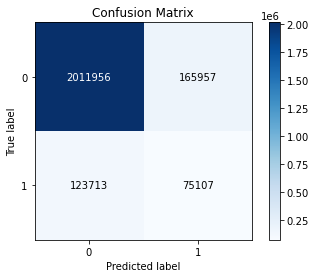

In [77]:
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred_log, y_test)))
print(classification_report(y_pred_log, y_test))

#plot confusion matrix
plot_confusion_matrix(y_pred_log, y_test)

In [72]:
print('Training Partition')
classificationSummary(y_train, xgb_model.predict(X_train))

# Identify and display confusion matrix for validation partition. 
print()
print('Testing Partition')
classificationSummary(y_test, xgb_model.predict(X_test))

Training Partition
Confusion Matrix (Accuracy 0.9041)

       Prediction
Actual       0       1
     0 4936118   46410
     1  485453   77729

Testing Partition
Confusion Matrix (Accuracy 0.9038)

       Prediction
Actual       0       1
     0 2115469   20200
     1  208423   32641


**Random Forest**

In [51]:
#Creating  model.
random_model = RandomForestClassifier(max_depth=6)

#fitting the model.
random_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

In [52]:
#prediction
#setting a threshold = 0.21
y_pred_rd = (random_model.predict_proba(X_test)[:, 1] >= 0.21).astype('int') 

#display the first 20 predictions
y_pred_rd[:20]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

F1 Score: 0.387689906328126
              precision    recall  f1-score   support

           0       0.91      0.93      0.92   2082204
           1       0.43      0.35      0.39    294529

    accuracy                           0.86   2376733
   macro avg       0.67      0.64      0.65   2376733
weighted avg       0.85      0.86      0.86   2376733



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

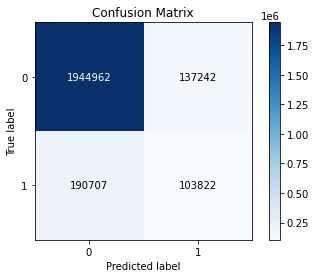

In [73]:
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred_rd, y_test)))
print(classification_report(y_pred_rd, y_test))

#plot confusion matrix
plot_confusion_matrix(y_pred_rd, y_test)

In [69]:
from dmba import classificationSummary

no display found. Using non-interactive Agg backend


In [70]:
print('Training Partition')
classificationSummary(y_train, random_model.predict(X_train))

# Identify and display confusion matrix for validation partition. 
print()
print('Testing Partition')
classificationSummary(y_test, random_model.predict(X_test))

Training Partition
Confusion Matrix (Accuracy 0.8992)

       Prediction
Actual       0       1
     0 4979366    3162
     1  555953    7229

Testing Partition
Confusion Matrix (Accuracy 0.8993)

       Prediction
Actual       0       1
     0 2134281    1388
     1  238013    3051
